# Gözetimli Öğrenme (Supervised Learning): Müşteri Terki

Gözetimli öğrenme üzerine bugün yapacağımız çalışmada müşteri terkini tahmin etmeye çalışacağız. Bu bir ikili sınıflandırma problemi. Müşteri sınıfları ise Sadık ve Terk Eden olarak adlandırılabilir.

İlk önce gözetimli öğrenmenin temellerine bakalım.

Gözetimli öğrenme bir programlama paradigması değişikliği. Klasik programlamada girdi ve kurallar verilir, çıktı aranır. Gözetimli öğrenmede ise girdi ve çıktılar verilir ve kurallar aranır. İki boyutlu bir örnek üzerinde kırmızı ve mavi noktaları ayıralım.

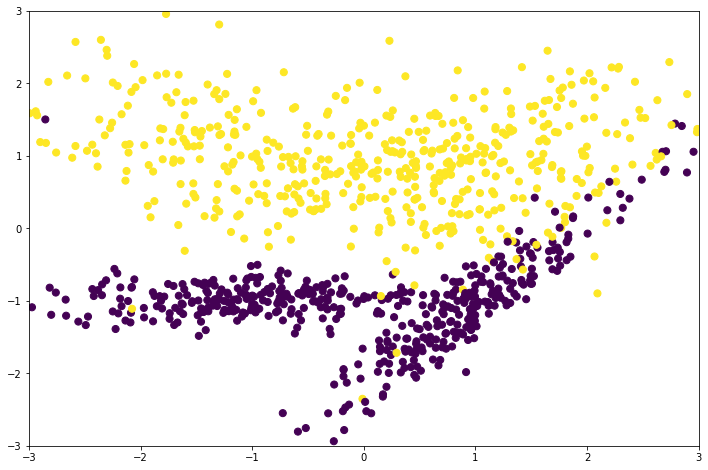

In [1]:
# Package for scientific computation
import numpy as np

# This allows us to visualize plots in the notebook and not as a separate window.
%matplotlib inline
#Package for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

#In order to generate artificial clustering and classification datasets
from sklearn.datasets import  make_classification

#vClassification algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# This is used in order to evaluate the results of a classifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score


# For supervised learning, we create an artificial dataset using 2 classes
n_samples = 1000
X,y = make_classification(n_samples= n_samples, n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=2, random_state=0)

#Let us plot the dataset with labels as colors
plt.figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s = 50)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show()

Gözetimli öğrenmede kullanılan yöntemlerin içeriği değişse de genelde (bazen matematiksel formüllerle ifade edilebilen) kurallar listesi çıkarılmak suretiyle gözlemler farklı sınıflara ayrılır. Aşağıda iki farklı metotla veriyi sınıflandırıyoruz. Kümelemede olduğu gibi burada da kurallar tarafından karar sınırları belirlenir.

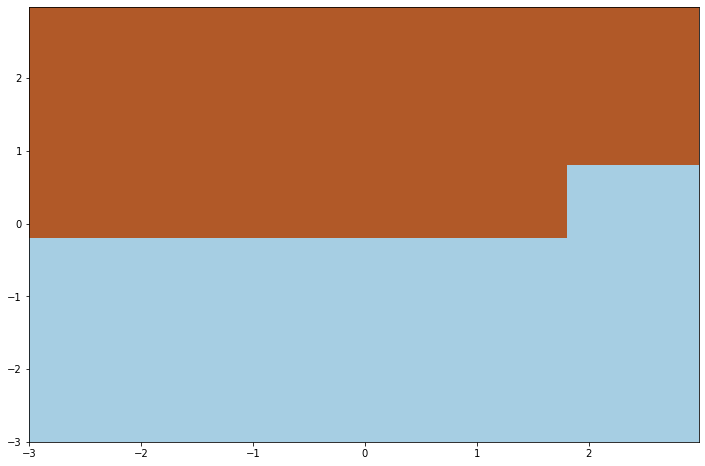

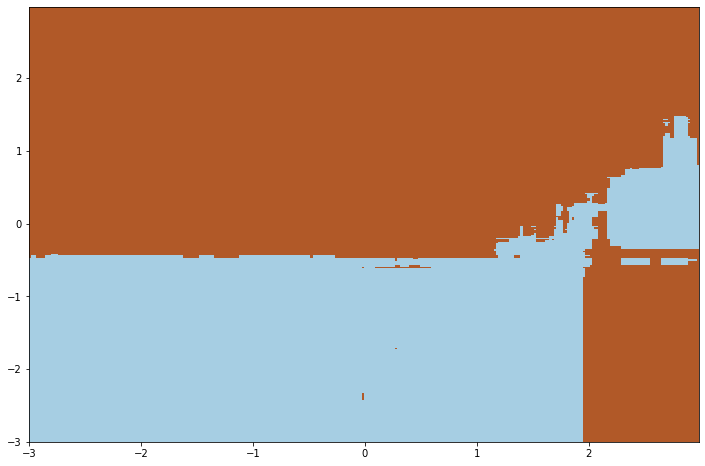

In [2]:
#Step size of meshgrid is required to draw decision boundaries
h = .02
xx, yy = np.meshgrid(np.arange(-3,3, h), np.arange(-3,3, h))

#We try different classifiers, decision tree, random forest, and gradient boosting.
#First we start by using decision trees
clf_dt = DecisionTreeClassifier(min_samples_leaf=20)
clf_dt.fit(X,y)

Z = clf_dt.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
#Use imshow to plot decision boundaries
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.show()

# Do the same for Random Forest
clf_rf = RandomForestClassifier(n_estimators = 100)
clf_rf.fit(X,y)

Z = clf_rf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.show()

Kurallar modellerinizin yapısına ve parametrelerine göre daha basit ya da zor olabilir.

**Önemli olan genel geçer olan ve sizin görmediğiniz veride tahmin yapmanızı sağlayacak kurallar oluşturmaktır.**

Müşteri terki için veri setini okutalım.

In [3]:
df_train = pd.read_csv('train.csv', index_col='CUSTOMER_NUMBER')
df_test = pd.read_csv('test.csv', index_col='CUSTOMER_NUMBER')

print(df_train.columns)

Index(['Son_Alisveris', 'Ilk_Alisveris', 'Tutar', 'Fis_Sayisi',
       'Sepet_Buyuklugu', 'SOn_Ceyrek_Fis', 'Son_Ceyrek_Yuzde', 'Kat_1_Yuzde',
       'Kat_2_Yuzde', 'Kat_3_Yuzde', 'Kat_4_Yuzde', 'Kat_5_Yuzde',
       'Indirim_Yuzde', 'Terk'],
      dtype='object')


İlk önce birkaç basit grafikle veriyi analiz edelim. Müşteri terkiyle aşağıdaki değişkenler arasında nasıl bir ilişki olmasını beklersiniz?
* Son alışverişten bu yana geçen zaman
* Fiş sayısı
* Alışveriş tutarı
* İndirim yüzdesi

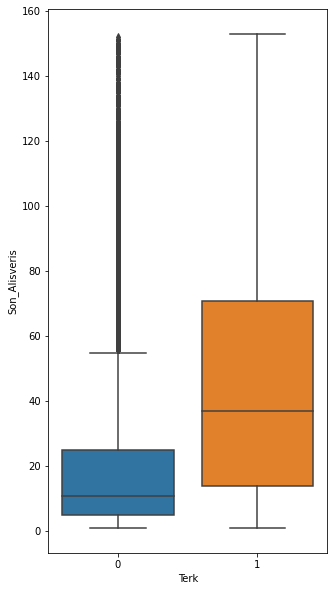

In [4]:
plt.figure(figsize= (5,10))
sns.boxplot(x="Terk", y="Son_Alisveris", data=df_train)
plt.show()

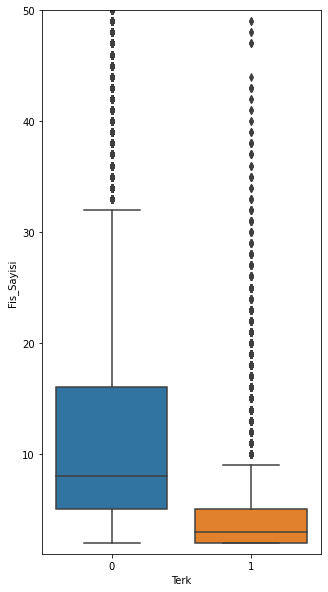

In [5]:
plt.figure(figsize= (5,10))
sns.boxplot(x="Terk", y="Fis_Sayisi", data=df_train)
plt.ylim((1,50))
plt.show()

Şimdi basit bir model eğiterek sonucuna bakalım. Bunu yapmadan önce veriyi etket ve özniteliklere ayırmamız gerekiyor. Aynı zamanda veride eksik değer olmaması lazım. Verinin yapısı nedeniyle eksik değerleri 0 ile doldurabiliriz.

In [6]:
y_train = df_train['Terk']
df_train.drop('Terk', inplace = True, axis = 1)
y_test = df_test['Terk']
df_test.drop('Terk', inplace = True, axis = 1)
df_train.fillna(0, inplace = True)
df_test.fillna(0, inplace = True)

Verinin boyutunu inceleyelim. Eğitim verisinin öznitelikleri ve etiketleri aynı boyutta olmalı (satır sayısı olarak). Aynı durum test verisi için de geçerli; ancak normalde bu verinin etiketleri tahmin etmek istediğiniz değerler olduğu için etiketlere erişiminiz olmayacaktır.

In [7]:
print(np.shape(df_train))
print(np.shape(y_train))
print(np.shape(df_test))
print(np.shape(y_test))

(63953, 13)
(63953,)
(57172, 13)
(57172,)


Şimdi derinliği 3 olan bir karar ağacı ile basit kurallar oluşturalım.

In [8]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth= 3, random_state = 0)
dt.fit(df_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

Karar ağacını çizdiriyoruz.

'dot' is not recognized as an internal or external command,
operable program or batch file.


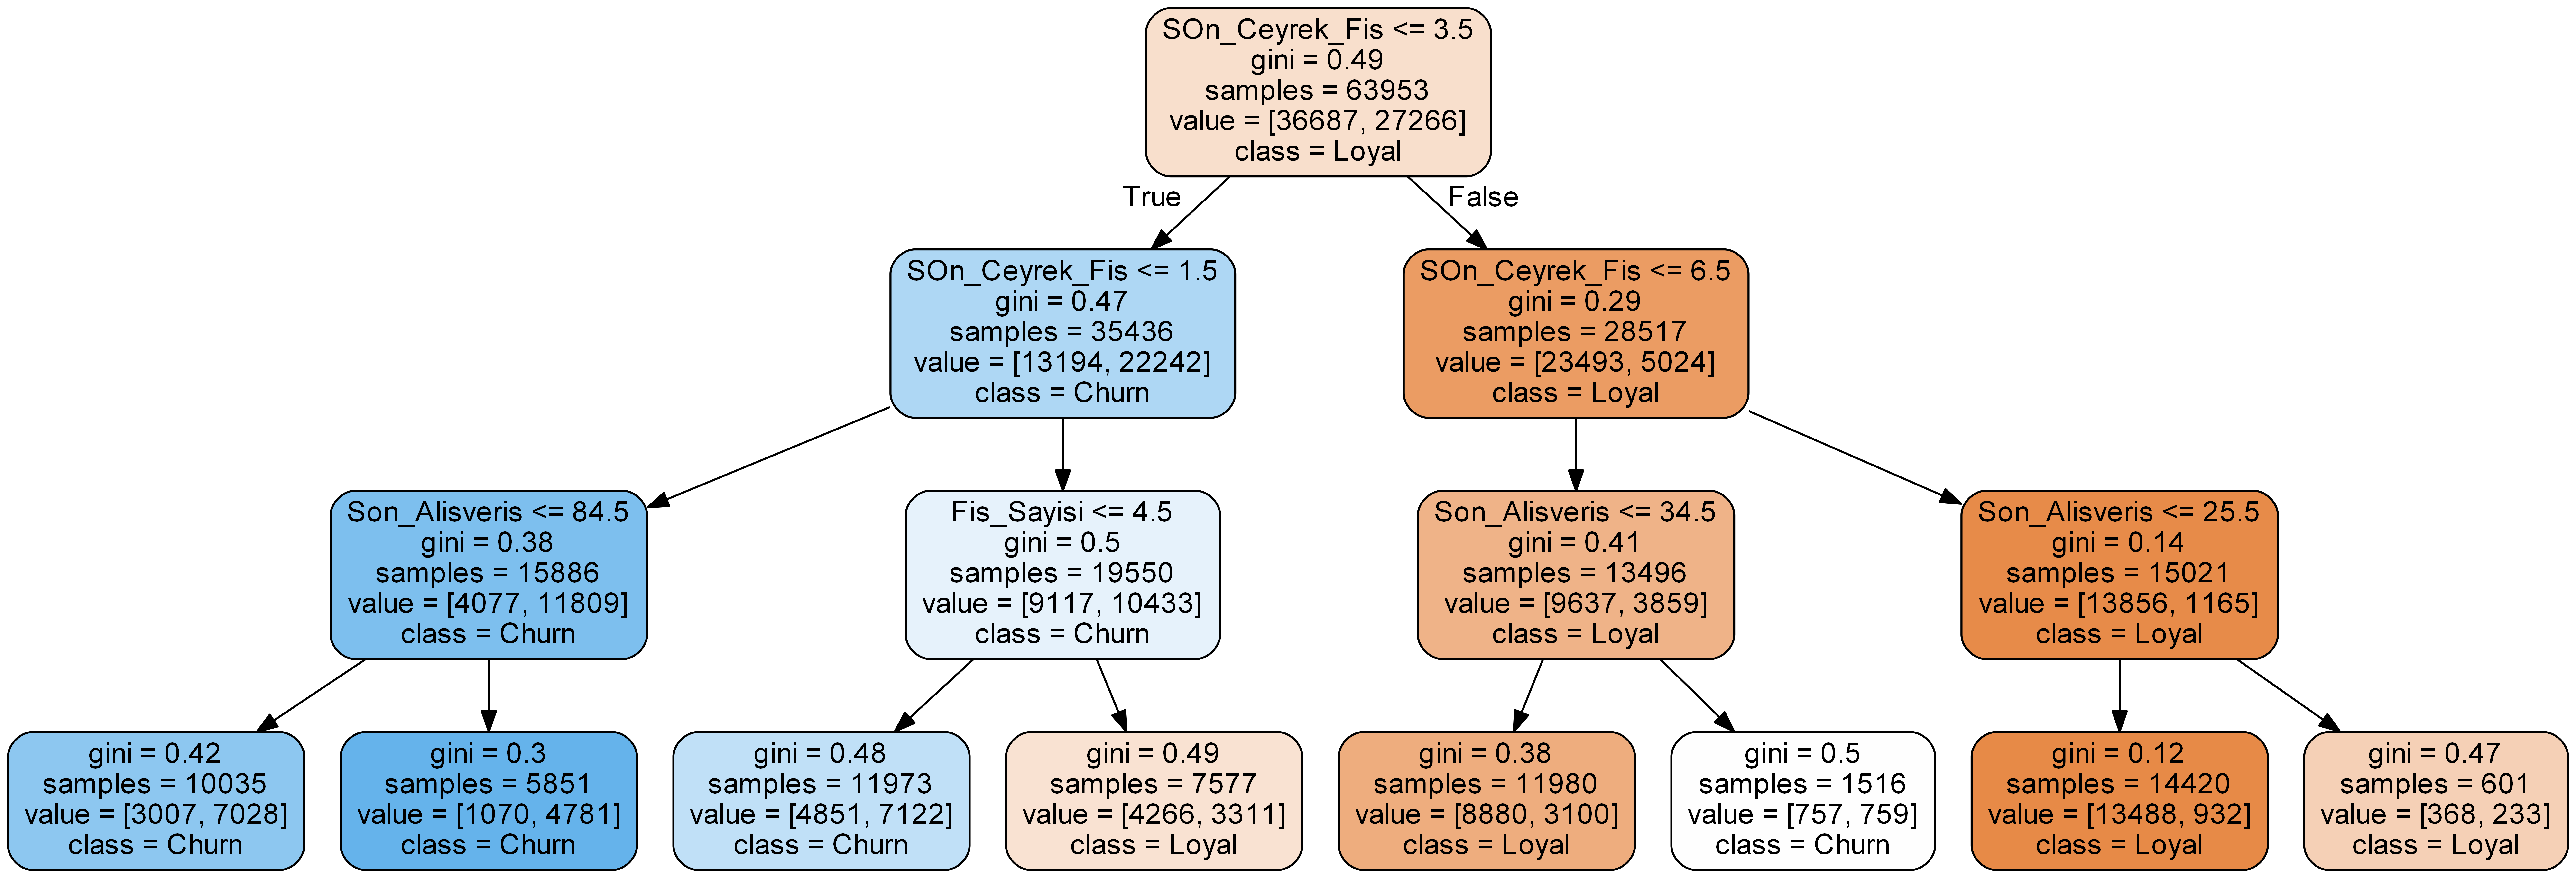

In [9]:
from sklearn.tree import export_graphviz
export_graphviz(dt, out_file='tree_limited.dot', feature_names = df_train.columns, class_names=['Loyal', 'Churn'],
                rounded = True, proportion = False, precision = 2, filled = True)

!dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=600

from IPython.display import Image
Image(filename = 'tree_limited.png')

İlk modelimizi çalıştırdık. Şimdi eğitim veri setindeki performansına bakalım.

In [10]:
y_pred = dt.predict(df_train)

from sklearn.metrics import confusion_matrix

df_res = pd.DataFrame(confusion_matrix(y_train, y_pred), index = ['True Loyal', 'True Churn'], columns= ['Predicted Loyal', 'Predicted Churn'])
df_res

,Predicted Loyal,Predicted Churn
True Loyal,27002,9685
True Churn,7576,19690


Karar ağacını basit tutmazsak daha isabetli tahminler yapabiliriz. Derinlik parametresini kaldıralım.

In [11]:
dt2 = DecisionTreeClassifier(random_state=0)
dt2.fit(df_train, y_train)
y_pred = dt2.predict(df_train)
df_res = pd.DataFrame(confusion_matrix(y_train, y_pred), index = ['True Loyal', 'True Churn'], columns= ['Predicted Loyal', 'Predicted Churn'])
df_res

,Predicted Loyal,Predicted Churn
True Loyal,36687,0
True Churn,0,27266


Bütün müşterileri doğru bildik! Şimdi öğrendiğimiz modeli güncel müşteriler için test verisinde uygulayalım.

In [12]:
y_pred2 = dt2.predict(df_test)
df_res = pd.DataFrame(confusion_matrix(y_test, y_pred2), index = ['True Loyal', 'True Churn'], columns= ['Predicted Loyal', 'Predicted Churn'])
df_res

,Predicted Loyal,Predicted Churn
True Loyal,22192,10492
True Churn,9663,14825


Başarı oranı %100'e yakın gibi durmuyor acaba ilk model daha mı başarılı sonuç verecek?

In [13]:
y_pred2 = dt.predict(df_test)
df_res = pd.DataFrame(confusion_matrix(y_test, y_pred2), index = ['True Loyal', 'True Churn'], columns= ['Predicted Loyal', 'Predicted Churn'])
df_res

,Predicted Loyal,Predicted Churn
True Loyal,23587,9097
True Churn,6588,17900


Öyle gözüküyor. Burada gördüğümüz olaya **overfitting (aşırı uyum)** deniyor. Sizin kurguladığınız modeller test verisinde doğru çalışmalı, bu amaçla da genel geçer kurallar öğrenmeli. Modelin limitlerini kaldırmak bunun önüne geçiyor. Güncel bir modeli test verisiyle öğrenemeyeceğiniz için eğitim verisinin bir bölümünü sonuçları kontrol etmek için kullanmanız gerekiyor. Burada iyi bir uygulama örneği **cross_validation (çapraz doğrulama)** ile parametreleri öğrenmektir. Aynı zamanda aşırı uyumu engellemeye yönelik topluluk öğrenmesi modelleri (Random Forest gibi) de mevcuttur.

İlk aşamada karar ağacının derinliği ve her yapraktaki en az gözlem sayısı için kimi parametreleri deneyelim. Bunu yaparken veri setini beş parçaya böleceğiz. 4 parça ile eğitilen model 5. parça üzerinde denenecek. Bu işlem 5 kere tekrarlandığında elde ettiğimiz ortalama performansı en yüksek modeli kullanarak bu sefer bütün eğitim verisiyle yeni bir model oluşturalım.

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

kfold = StratifiedKFold(n_splits=5, shuffle = True)

dt = DecisionTreeClassifier()

parameters = {'min_samples_leaf': [20, 50, 100],
             'max_depth': [3,5,7,9]}

grid_search = GridSearchCV(dt, param_grid= parameters, cv= kfold, verbose =2)
grid_search.fit(df_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=3, min_samples_leaf=20 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. max_depth=3, min_samples_leaf=20, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ................. max_depth=3, min_samples_leaf=20, total=   0.3s
[CV] max_depth=3, min_samples_leaf=20 ................................
[CV] ................. max_depth=3, min_samples_leaf=20, total=   0.3s
[CV] max_depth=3, min_samples_leaf=20 ................................
[CV] ................. max_depth=3, min_samples_leaf=20, total=   0.4s
[CV] max_depth=3, min_samples_leaf=20 ................................
[CV] ................. max_depth=3, min_samples_leaf=20, total=   0.4s
[CV] max_depth=3, min_samples_leaf=50 ................................
[CV] ................. max_depth=3, min_samples_leaf=50, total=   0.3s
[CV] max_depth=3, min_samples_leaf=50 ................................
[CV] ................. max_depth=3, min_samples_leaf=50, total=   0.3s
[CV] max_depth=3, min_samples_leaf=50 ................................
[CV] ................. max_depth=3, min_samples_leaf=50, total=   0.4s
[CV] max_depth=3, min_samples_leaf=50 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   33.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [20, 50, 100]},
             verbose=2)

En iyi modelin özelliklerine bakalım.

In [15]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=20)
0.7357278686654739


En iyi modeli bütün eğitim veri kümesiyle eğiterek sonuçları alalım.

In [16]:
dt = grid_search.best_estimator_
dt.fit(df_train,y_train)

y_pred = dt.predict(df_test)
df_res = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['True Loyal', 'True Churn'], columns= ['Predicted Loyal', 'Predicted Churn'])
df_res

,Predicted Loyal,Predicted Churn
True Loyal,23015,9669
True Churn,5660,18828


Normal koşullar altında topluluk öğrenmesi yöntemlerinden Random Forest algoritması karar ağaçlarına tercih edilir. Bu yöntem çok sayıda rassal karar ağacı oluşturarak bunların hepsinin öğrendiği modelleri kullanarak tahmin yapar. Aşırı uyum gibi problemlere karşı dayanıklıdır.

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)

rf.fit(df_train,y_train)
y_pred = rf.predict(df_test)
df_res = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['True Loyal', 'True Churn'], columns= ['Predicted Loyal', 'Predicted Churn'])
df_res

,Predicted Loyal,Predicted Churn
True Loyal,24167,8517
True Churn,6962,17526


Karar ağaçlarında daha başarılı bir sonuç elde edemedik. İsterseniz parametrelerle oynayarak daha başarılı bir model oluşturmaya çalışabiliriz.

Bir çok yöntem sınıflandırma problemlerinde gözlemlerin sınıflara ait olma olasılığını da döndürür. Karar ağaçları ve Random Forest yönteminin herhangi bir müşteri için döndürdüğü olasılıklara bakalım.

In [18]:
print('Sadık müşteri')
musteri = df_test.iloc[0,:]
print(y_test.iloc[0])
print('Karar ağacı')
print('Sadık olma olasılığı: ' + str(dt.predict_proba(musteri.values.reshape(1,-1))[0][0]))
print('Terk etme olasılığı: ' + str(dt.predict_proba(musteri.values.reshape(1,-1))[0][1]))
print('Random Forest')
print('Sadık olma olasılığı: ' + str(rf.predict_proba(musteri.values.reshape(1,-1))[0][0]))
print('Terk etme olasılığı: ' + str(rf.predict_proba(musteri.values.reshape(1,-1))[0][1]))

Sadık müşteri
0
Karar ağacı
Sadık olma olasılığı: 0.9657449442839455
Terk etme olasılığı: 0.03425505571605448
Random Forest
Sadık olma olasılığı: 1.0
Terk etme olasılığı: 0.0


Olasılıklar üzerinde eğri altı alan değerlendirilebilir. Eğri altı alan olasılıkları sınıflara dönüştürmek için kullanacağımız eşik değerlere göre belirlenir ve yapacağımız tahmindeki isabetliliği terk edip etmeme durumuna göre belirlememizi sağlar.

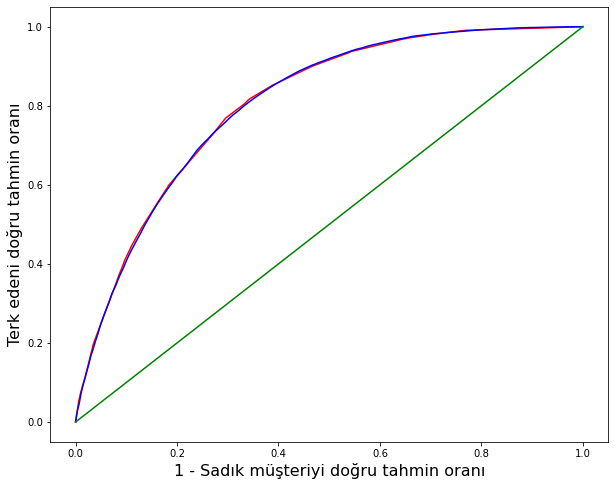

In [19]:
from sklearn.metrics import roc_curve
y_pred_proba_dt = dt.predict_proba(df_test)
y_pred_proba_rf = rf.predict_proba(df_test)

a_dt,b_dt,c_dt = roc_curve(y_test,y_pred_proba_dt[:,1])
a_rf,b_rf,c_rf = roc_curve(y_test, y_pred_proba_rf[:,1])

plt.figure(figsize =(10,8))
plt.plot(a_dt, b_dt, c='red')
plt.plot(a_rf,b_rf, c='blue')
plt.plot([0,1],[0,1], c= 'green')
plt.ylabel('Terk edeni doğru tahmin oranı', fontsize=16)
plt.xlabel('1 - Sadık müşteriyi doğru tahmin oranı', fontsize = 16)
plt.show()